In [1]:
# Cell 1: Setup
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d

λ_grid = np.arange(500, 801, 1)
fluor_names = ['JF525','JF552','JF608','JFX673','JF722']
spectra_dir = Path("../data/spectra_npz")

# Cell 2: Load and interpolate spectra
def load_and_interpolate(fluor_names, spectra_dir, λ_grid):
    spectra = {}
    for name in fluor_names:
        path = spectra_dir / f"{name}.npz"
        data = np.load(path)
        wl = data["wavelengths_emission"]
        em = data["emission"] / data["emission"].max()
        interp = interp1d(wl, em, bounds_error=False, fill_value=0.0)
        spectra[name] = interp(λ_grid)
    return spectra

interpolated_emissions = load_and_interpolate(fluor_names, spectra_dir, λ_grid)


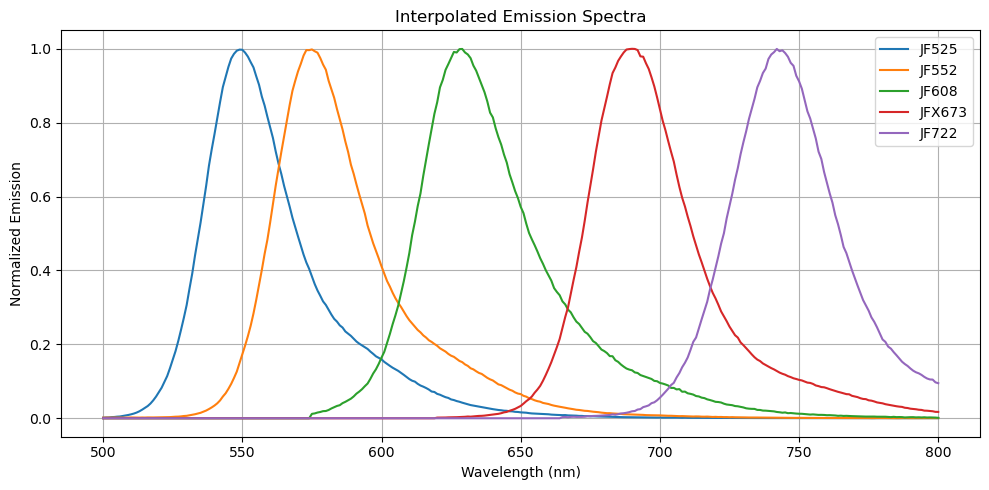

In [2]:
# Cell 3: Plot interpolated spectra
plt.figure(figsize=(10, 5))
for name in fluor_names:
    plt.plot(λ_grid, interpolated_emissions[name], label=name)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Emission")
plt.title("Interpolated Emission Spectra")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


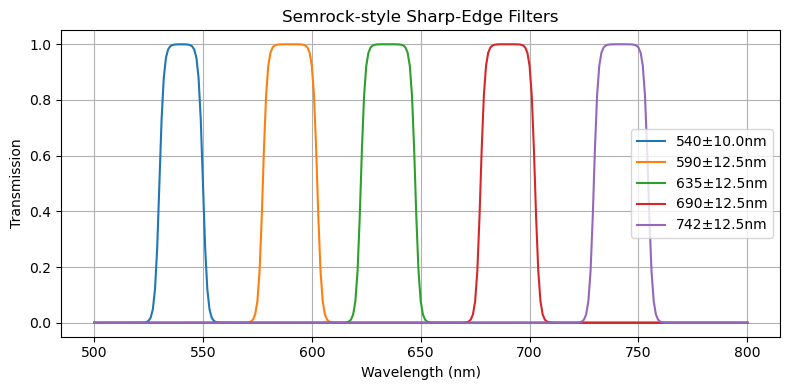

In [18]:
# Cell: Define semrock-style bandpass filters
import numpy as np
import matplotlib.pyplot as plt

def semrock_filter(λ_grid, center, FWHM, edge_steepness=1.0):
    """
    Create a Semrock-like bandpass filter:
      - Flat top between center ± FWHM/2
      - Steep edges modeled by logistic transitions
    """
    half = FWHM / 2
    # Compute sigmoid transitions
    low = 1 / (1 + np.exp(-(λ_grid - (center - half)) * edge_steepness))
    high = 1 / (1 + np.exp((λ_grid - (center + half)) * edge_steepness))
    return low * high

# Example: 5 channels
centers = [540, 590, 635, 690, 742]
FWHMs = [20, 25, 25, 25, 25]  # Typical Semrock bandwidths :contentReference[oaicite:4]{index=4}
edge_steepness = 0.99  # Adjust for sharper or softer transitions

# Generate filters
filters = np.stack([
    semrock_filter(λ_grid, c, w, edge_steepness) 
    for c, w in zip(centers, FWHMs)
])

# Plot for review
plt.figure(figsize=(8,4))
for i, f in enumerate(filters):
    plt.plot(λ_grid, f, label=f"{centers[i]}±{FWHMs[i]/2}nm")
plt.title("Semrock-style Sharp-Edge Filters")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


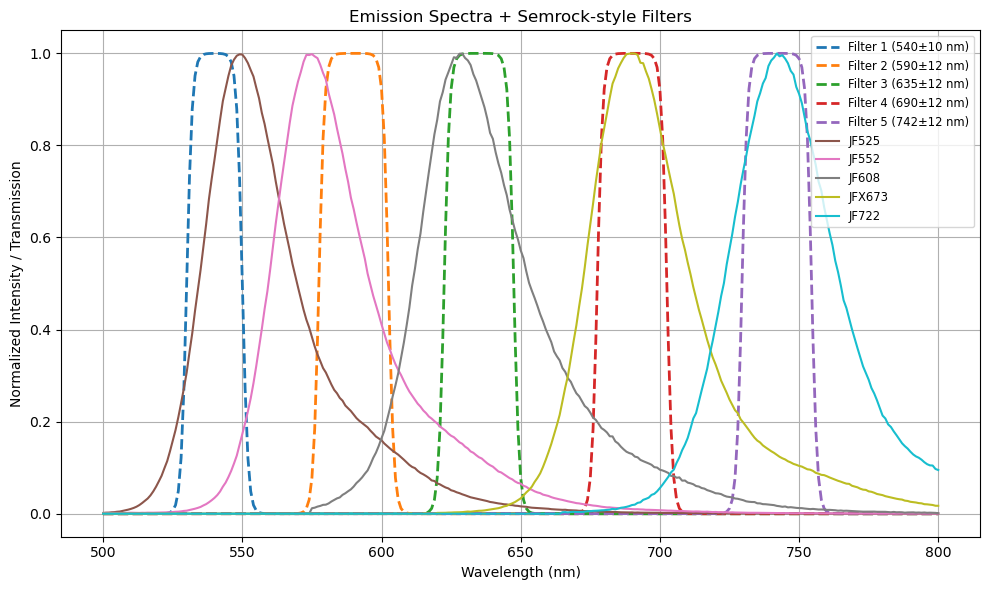

In [19]:
# Cell: Plot filters and emission spectra together
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot filters (dashed lines)
for i, f in enumerate(filters):
    plt.plot(λ_grid, f, '--', label=f'Filter {i+1} ({centers[i]}±{FWHMs[i]//2} nm)', linewidth=2)

# Plot emissions (solid lines)
for name in fluor_names:
    plt.plot(λ_grid, interpolated_emissions[name], label=name, linewidth=1.5)

plt.title("Emission Spectra + Semrock-style Filters")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity / Transmission")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


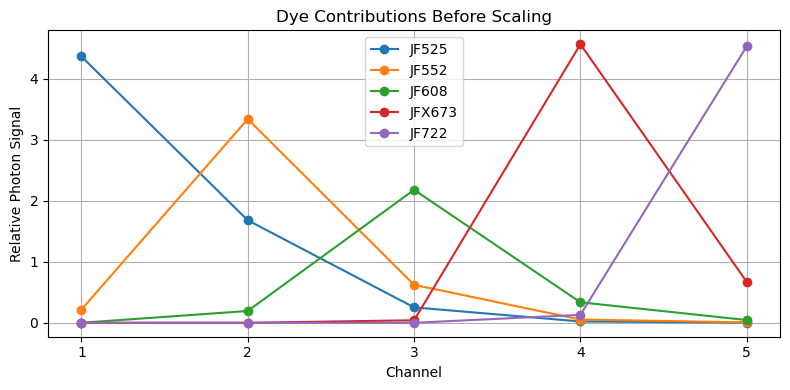

In [56]:
# Step 1: Choose dye amplitudes (mixture proportions)

dye_amplitudes = np.array([0.3, 0.2, 0.1, 0.2, 0.2])  # shape (N_dyes,)
N = len(dye_amplitudes)
C = filters.shape[0]

# Step 2: Compute signal from each dye through each channel
dye_signals = np.zeros((N, C))  # (N_dyes, N_channels)

for i, (name, amp) in enumerate(zip(fluor_names, dye_amplitudes)):
    spectrum = interpolated_emissions[name]  # shape (λ,)
    filtered = filters * spectrum            # shape (C, λ)
    dye_signals[i] = amp * np.sum(filtered, axis=1)  # shape (C,)

# Step 3: Visualize individual dye contributions per channel
plt.figure(figsize=(8, 4))
for i in range(N):
    plt.plot(np.arange(1, C+1), dye_signals[i], marker='o', label=f"{fluor_names[i]}")
plt.xticks(np.arange(1, C+1))
plt.xlabel("Channel")
plt.ylabel("Relative Photon Signal")
plt.title("Dye Contributions Before Scaling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


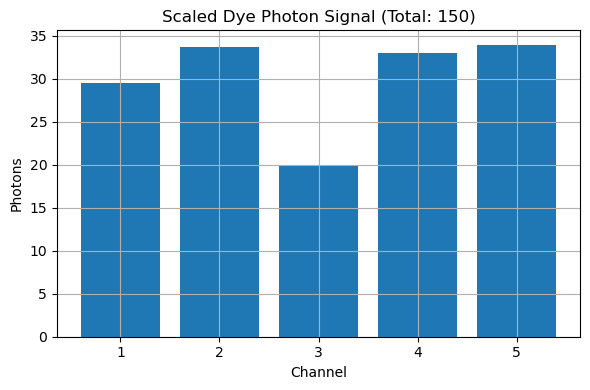

In [57]:
# Step 4: Scale to total dye photons
total_dye_photons = 1.5e2
sum_signal = dye_signals.sum()
dye_photon_signal = dye_signals.sum(axis=0) / sum_signal * total_dye_photons if sum_signal > 0 else np.zeros(C)

# Visualize photon signal from dyes
plt.figure(figsize=(6, 4))
plt.bar(np.arange(1, C+1), dye_photon_signal)
plt.xticks(np.arange(1, C+1))
plt.ylabel("Photons")
plt.xlabel("Channel")
plt.title(f"Scaled Dye Photon Signal (Total: {int(total_dye_photons)})")
plt.grid(True)
plt.tight_layout()
plt.show()


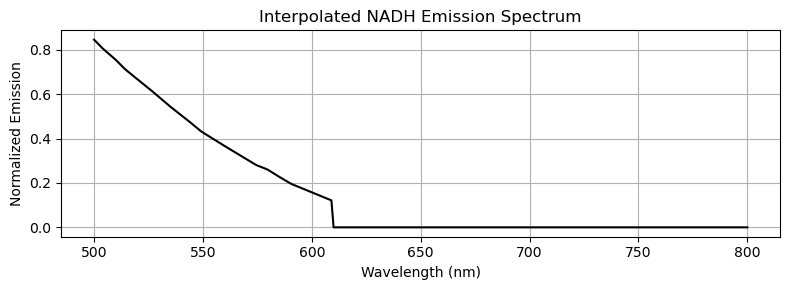

In [58]:
# Step 1: Load NADH spectrum
nadh_path = spectra_dir / "NADH.npz"
nadh_data = np.load(nadh_path)
nadh_wl = nadh_data["wavelengths_emission"]
nadh_em = nadh_data["emission"]
nadh_em /= nadh_em.max()  # normalize

# Interpolate onto λ_grid
from scipy.interpolate import interp1d
interp_nadh = interp1d(nadh_wl, nadh_em, bounds_error=False, fill_value=0)
nadh_em_interp = interp_nadh(λ_grid)

# Plot NADH spectrum
plt.figure(figsize=(8, 3))
plt.plot(λ_grid, nadh_em_interp, label="NADH Emission", color='black')
plt.title("Interpolated NADH Emission Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Emission")
plt.grid(True)
plt.tight_layout()
plt.show()


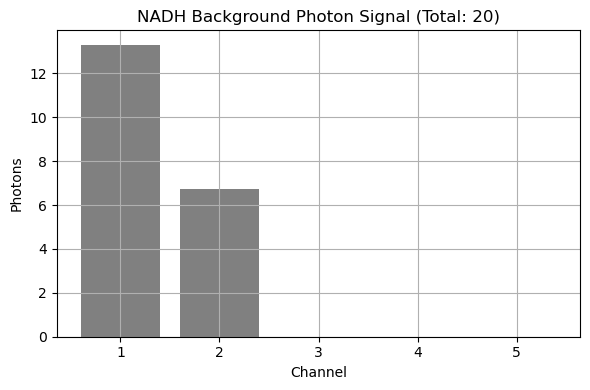

In [59]:
# Step 2: Compute NADH signal through filters
bg_filtered = np.sum(filters * nadh_em_interp, axis=1)
bg_filtered /= bg_filtered.sum()  # normalize to 1

total_background_photons = 2e1
background_photon_signal = bg_filtered * total_background_photons

# Plot NADH-based background signal
plt.figure(figsize=(6, 4))
plt.bar(np.arange(1, C+1), background_photon_signal, color='gray')
plt.xticks(np.arange(1, C+1))
plt.ylabel("Photons")
plt.xlabel("Channel")
plt.title(f"NADH Background Photon Signal (Total: {int(total_background_photons)})")
plt.grid(True)
plt.tight_layout()
plt.show()


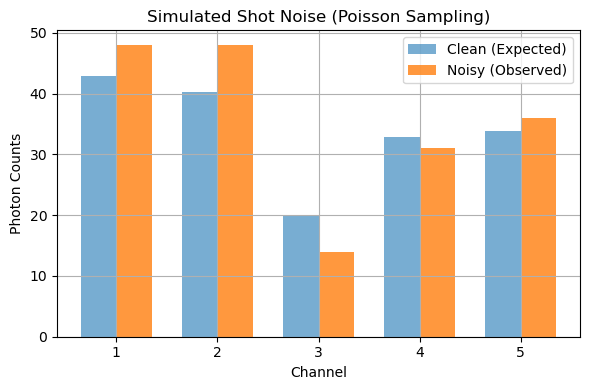

Channel 1: Clean = 42.8, Noisy = 48
Channel 2: Clean = 40.3, Noisy = 48
Channel 3: Clean = 20.0, Noisy = 14
Channel 4: Clean = 32.9, Noisy = 31
Channel 5: Clean = 33.9, Noisy = 36


In [60]:
# Step 1: Combine dye + background photon signal (if not already done)
total_signal = dye_photon_signal + background_photon_signal

# Step 2: Apply Poisson noise to simulate photon counting variability
rng = np.random.default_rng(seed=42)  # fixed seed for reproducibility
noisy_counts = rng.poisson(total_signal).astype(float)

# Step 3: Plot noisy vs clean signal
plt.figure(figsize=(6, 4))
width = 0.35
channels = np.arange(1, C+1)
plt.bar(channels - width/2, total_signal, width=width, label='Clean (Expected)', alpha=0.6)
plt.bar(channels + width/2, noisy_counts, width=width, label='Noisy (Observed)', alpha=0.8)
plt.xticks(channels)
plt.ylabel("Photon Counts")
plt.xlabel("Channel")
plt.title("Simulated Shot Noise (Poisson Sampling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Print numeric results
for i, (clean, noisy) in enumerate(zip(total_signal, noisy_counts), 1):
    print(f"Channel {i}: Clean = {clean:.1f}, Noisy = {int(noisy)}")


In [30]:
# In [1]: Imports and Setup
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust path as needed
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import SNPE, simulate_for_sbi
from multiplex_sim import Microscope, io, plotting

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
def batch_simulator(theta_batch, λ_grid, interpolated_emissions, nadh_em_interp, edge_steepness=1,
                    total_dye_photons=1.5e2, total_background_photons=2e1, rng_seed=42):
    """
    theta_batch: torch.Tensor of shape (B, 15)
        [amp_1..5, σ_1..5, center_1..5]
    Returns:
        x_batch: torch.Tensor of shape (B, 5)
    """
    B = theta_batch.shape[0]
    C = 5
    x_batch = []

    rng = np.random.default_rng(seed=rng_seed)

    for θ in theta_batch:
        θ_np = θ.numpy()
        amps = θ_np[:5]
        sigmas = θ_np[5:10]
        centers = θ_np[10:15]

        # Build filters
        filters = np.stack([
            1 / (1 + np.exp(-(λ_grid - (c - w/2)) * edge_steepness)) *
            1 / (1 + np.exp((λ_grid - (c + w/2)) * edge_steepness))
            for c, w in zip(centers, sigmas)
        ])  # shape (5, λ)

        # Dye signals
        dye_signals = np.zeros((5, C))
        for i, (name, amp) in enumerate(zip(interpolated_emissions.keys(), amps)):
            spectrum = interpolated_emissions[name]
            dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)

        signal_sum = dye_signals.sum()
        dye_photon_signal = dye_signals.sum(axis=0) / signal_sum * total_dye_photons if signal_sum > 0 else np.zeros(C)

        # NADH background
        bg_signal = np.sum(filters * nadh_em_interp, axis=1)
        bg_signal /= bg_signal.sum() if bg_signal.sum() > 0 else 1
        background_photon_signal = bg_signal * total_background_photons

        # Total signal and noise
        total_signal = dye_photon_signal + background_photon_signal
        noisy_counts = rng.poisson(total_signal).astype(np.float32)

        x_batch.append(noisy_counts)

    return torch.tensor(x_batch, dtype=torch.float32)


In [42]:
peak_centers = {
    name: λ_grid[np.argmax(em)] 
    for name, em in interpolated_emissions.items()
}
print("Peak emission per dye:", peak_centers)


Peak emission per dye: {'JF525': np.int64(549), 'JF552': np.int64(575), 'JF608': np.int64(629), 'JFX673': np.int64(690), 'JF722': np.int64(742)}


In [ ]:
# Sample from the priors
num_samples = 5000
samples = sample_joint_prior(num_samples)
amps_samp = samples[:, :5]
widths_samp = samples[:, 5:10]
centers_samp = samples[:, 10:15]

# Prepare peak center reference
peak_centers_array = np.array([peak_centers[name] for name in fluor_names])
bandwidth_means = μ_bw.numpy()

# Plot centers
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
for i, name in enumerate(fluor_names):
    axs[i].hist(centers_samp[:, i].numpy(), bins=40, alpha=0.7, color='goldenrod')
    axs[i].axvline(peak_centers_array[i], color='red', linestyle='--', label='Emission Peak')
    axs[i].set_title(f"{name} λ₀ prior")
    axs[i].set_xlabel("nm")
    if i == 0: axs[i].set_ylabel("Samples")
    axs[i].grid(True)
    axs[i].legend()
plt.suptitle("Priors over Filter Centers")
plt.tight_layout()
plt.show()


In [45]:
from torch import Tensor
from sbi.utils import BoxUniform
from torch.distributions import MultivariateNormal
class FluorFilterPrior:
    """Custom prior matching the sbi interface, with return_numpy support."""

    def __init__(
        self,
        amp_bounds: tuple,
        σ_mean: Tensor,
        σ_std: Tensor,
        λ_mean: Tensor,
        λ_std: Tensor,
        return_numpy: bool = False
    ):
        self.amp_prior = BoxUniform(low=amp_bounds[0], high=amp_bounds[1])
        self.σ_prior = MultivariateNormal(σ_mean, torch.diag(σ_std**2))
        self.λ_prior = MultivariateNormal(λ_mean, torch.diag(λ_std**2))
        self.return_numpy = return_numpy

    def sample(self, sample_shape=torch.Size([])):
        n = sample_shape[0] if len(sample_shape) > 0 else 1
        amps = self.amp_prior.sample((n,))
        widths = self.σ_prior.sample((n,))
        centers = self.λ_prior.sample((n,))
        samples = torch.cat([amps, widths, centers], dim=1)
        return samples.numpy() if self.return_numpy else samples

    def log_prob(self, values):
        if self.return_numpy:
            values = torch.as_tensor(values)
        amp = values[:, :5]
        σs = values[:, 5:10]
        λs = values[:, 10:15]
        log_probs = (
            self.amp_prior.log_prob(amp) +
            self.σ_prior.log_prob(σs) +
            self.λ_prior.log_prob(λs)
        )
        return log_probs.numpy() if self.return_numpy else log_probs


In [48]:
from sbi.utils import process_prior

# Setup bounds + Gaussian parameters
amp_bounds = (torch.zeros(5), torch.ones(5))
σ_mean = torch.tensor([25.0] * 5)
σ_std = torch.tensor([7.0] * 5)

λ_mean = torch.tensor([peak_centers[name] for name in fluor_names], dtype=torch.float32)
λ_std = torch.tensor([10.0] * 5)

# Create and wrap prior
custom_prior_obj = FluorFilterPrior(amp_bounds, σ_mean, σ_std, λ_mean, λ_std)

# Wrap into a torch-compatible distribution
prior, *_ = process_prior(
    custom_prior_obj,
    custom_prior_wrapper_kwargs=dict(
        lower_bound=torch.cat([amp_bounds[0], σ_mean - 3*σ_std, λ_mean - 3*λ_std]),
        upper_bound=torch.cat([amp_bounds[1], σ_mean + 3*σ_std, λ_mean + 3*λ_std]),
    )
)


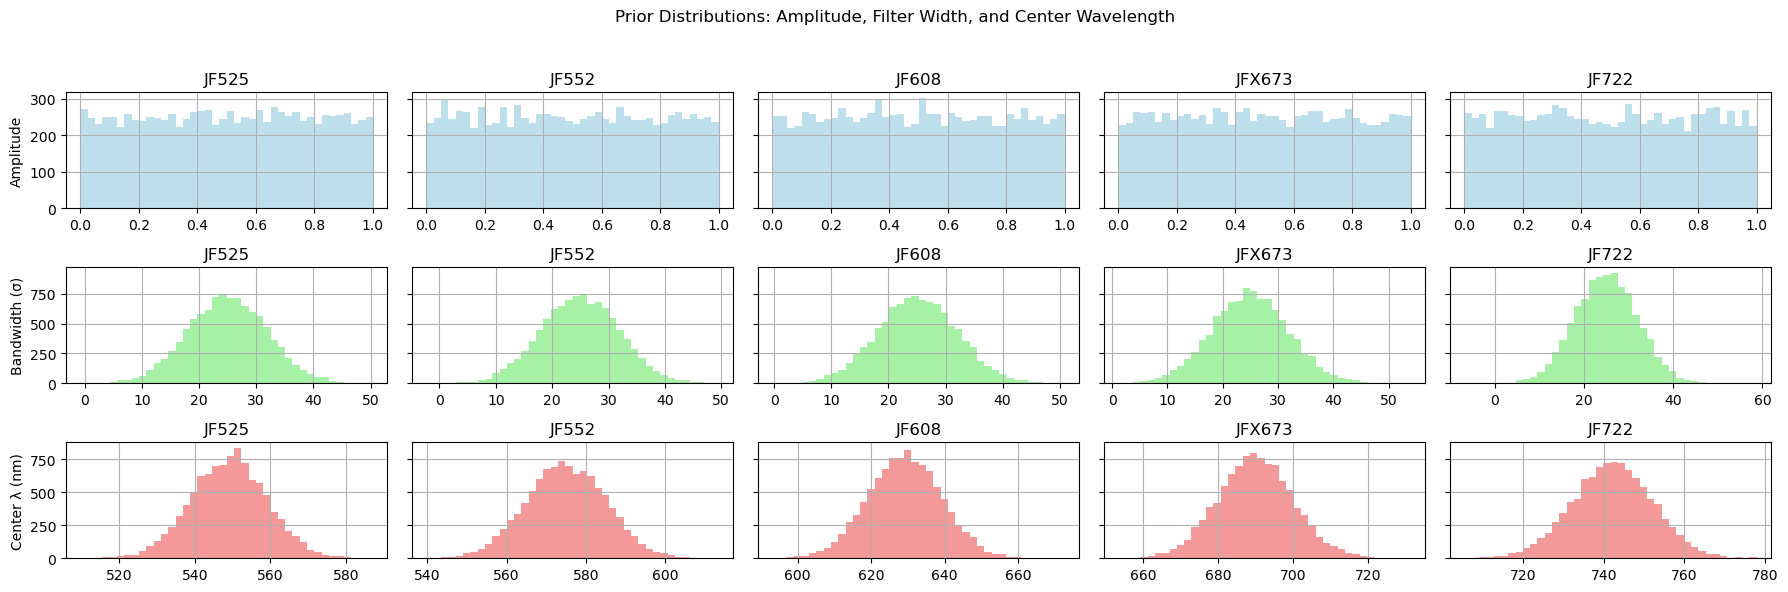

In [52]:
import matplotlib.pyplot as plt

def plot_fluor_filter_prior(prior, fluor_names, num_samples=5000):
    """
    Plot the prior distributions for dye amplitudes, filter widths, and centers.

    Args:
        prior: instance of FluorFilterPrior
        fluor_names: list of dye names, must be length 5
        num_samples: number of samples to draw
    """
    samples = prior.sample((num_samples,))
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)

    amps = samples[:, :5].numpy()
    widths = samples[:, 5:10].numpy()
    centers = samples[:, 10:15].numpy()

    fig, axs = plt.subplots(3, 5, figsize=(18, 6), sharey='row')
    rows = ['Amplitude', 'Bandwidth (σ)', 'Center λ (nm)']

    for i in range(5):
        axs[0, i].hist(amps[:, i], bins=40, color='lightblue', alpha=0.8)
        axs[1, i].hist(widths[:, i], bins=40, color='lightgreen', alpha=0.8)
        axs[2, i].hist(centers[:, i], bins=40, color='lightcoral', alpha=0.8)

        for j in range(3):
            axs[j, i].set_title(f"{fluor_names[i]}")
            axs[j, i].grid(True)
            if i == 0:
                axs[j, i].set_ylabel(rows[j])
            axs[j, i].set_xlabel("")

    plt.suptitle("Prior Distributions: Amplitude, Filter Width, and Center Wavelength")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_fluor_filter_prior(prior, fluor_names, 10000)

In [68]:

inference = sbi_inference.SNPE(prior)

# Wrapper to use with simulate_for_sbi
sim_fn = lambda θ: batch_simulator(θ, λ_grid, interpolated_emissions, nadh_em_interp)

θ, x = simulate_for_sbi(sim_fn, prior, num_simulations=100000)

# Train posterior
density_estimator = inference.append_simulations(θ, x).train()
posterior = inference.build_posterior(density_estimator)


100%|██████████| 100000/100000 [00:10<00:00, 9136.03it/s]


 Neural network successfully converged after 229 epochs.

In [69]:
# Pick ground-truth θ to simulate x_obs

centers = [540, 590, 635, 690, 742]
FWHMs = [20, 25, 25, 25, 25]  # Typical Semrock bandwidths :contentReference[oaicite:4]{index=4}
dye_amplitudes = np.array([0.3, 0.2, 0.1, 0.2, 0.2])  # shape (N_dyes,)
θ_true = np.concatenate([
    np.array(dye_amplitudes),  # dye amplitudes
    np.array(FWHMs),       # filter FWHMs
    np.array(centers)   # centers
])
x_obs_np = batch_simulator(
    theta_batch=torch.tensor([θ_true]),
    λ_grid=λ_grid,
    interpolated_emissions=interpolated_emissions,
    nadh_em_interp=nadh_em_interp,
    rng_seed=123
)[0]  # just the first row


In [70]:
# Sample 1000 θ from posterior conditioned on x_obs
x_obs = torch.tensor(x_obs_np).float()
samples = posterior.sample((1000000,), x=x_obs)

# Extract just dye amplitudes (first 5 dims)
amplitude_samples = samples[:, :5]


/tmp/ipykernel_1034372/3946614628.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_obs = torch.tensor(x_obs_np).float()
Drawing 1000000 posterior samples: 1001468it [00:13, 72788.31it/s]                            


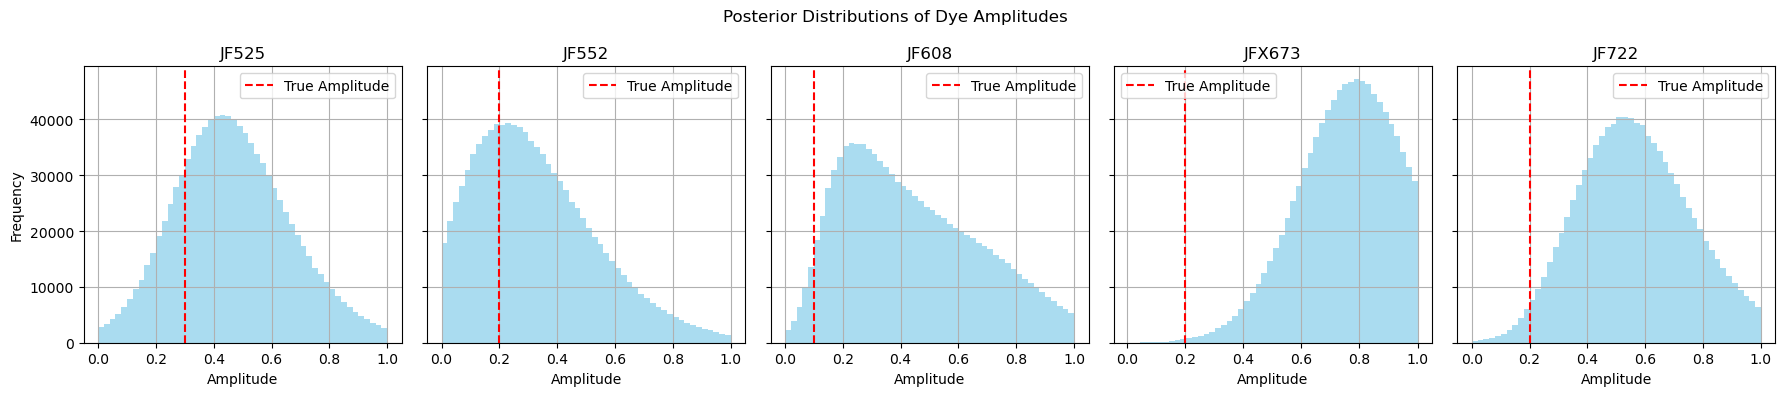

In [71]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)

for i, name in enumerate(fluor_names):
    axs[i].hist(amplitude_samples[:, i].numpy(), bins=50, alpha=0.7, color='skyblue')
    axs[i].axvline(θ_true[i], color='red', linestyle='--', label='True Amplitude')
    axs[i].set_title(name)
    axs[i].set_xlabel("Amplitude")
    axs[i].grid(True)
    if i == 0:
        axs[i].set_ylabel("Frequency")
    axs[i].legend()

plt.suptitle("Posterior Distributions of Dye Amplitudes")
plt.tight_layout()
plt.show()


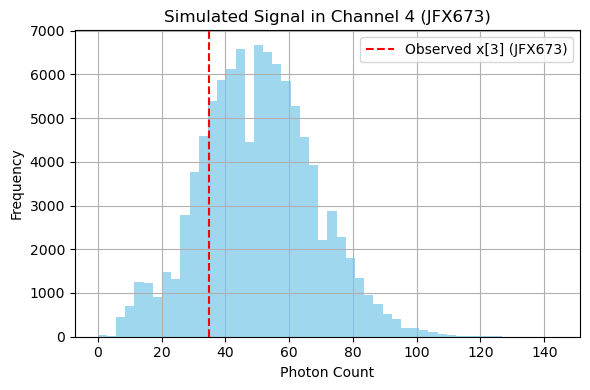

In [72]:
import matplotlib.pyplot as plt

# 1. Distribution of signal in channel 4
plt.figure(figsize=(6, 4))
plt.hist(x[:, 1].numpy(), bins=50, color='skyblue', alpha=0.8)
plt.axvline(x_obs[1].item(), color='red', linestyle='--', label='Observed x[3] (JFX673)')
plt.title("Simulated Signal in Channel 4 (JFX673)")
plt.xlabel("Photon Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


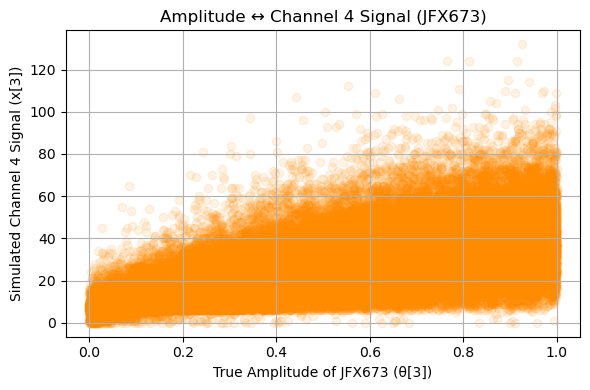

In [73]:
# 2. Correlation between JFX673 amplitude and Ch4 signal
plt.figure(figsize=(6, 4))
plt.scatter(θ[:, 3].numpy(), x[:, 3].numpy(), alpha=0.1, color='darkorange')
plt.xlabel("True Amplitude of JFX673 (θ[3])")
plt.ylabel("Simulated Channel 4 Signal (x[3])")
plt.title("Amplitude ↔ Channel 4 Signal (JFX673)")
plt.grid(True)
plt.tight_layout()
plt.show()


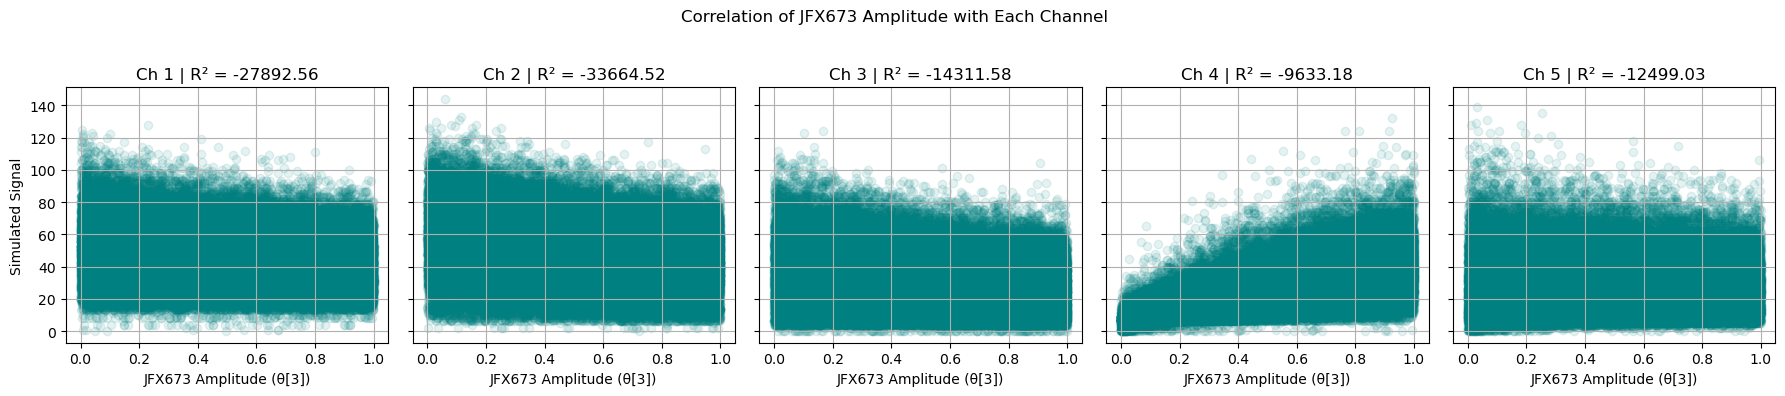

In [74]:
import numpy as np
from sklearn.metrics import r2_score

amp_index = 3  # JFX673 is the 4th dye → index 3
dye_name = fluor_names[amp_index]

amp_true = θ[:, amp_index].numpy()
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)

r2_vals = []

for ch in range(5):
    ch_signal = x[:, ch].numpy()
    r2 = r2_score(amp_true, ch_signal)
    r2_vals.append(r2)

    axs[ch].scatter(amp_true, ch_signal, alpha=0.1, color='teal')
    axs[ch].set_title(f"Ch {ch+1} | R² = {r2:.2f}")
    axs[ch].set_xlabel(f"{dye_name} Amplitude (θ[3])")
    axs[ch].grid(True)
    if ch == 0:
        axs[ch].set_ylabel("Simulated Signal")

plt.suptitle(f"Correlation of {dye_name} Amplitude with Each Channel")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [75]:
import torch
import os
from datetime import datetime

def save_sbi_checkpoint(posterior, prior=None, θ=None, x=None, x_obs=None, tag=None, save_dir="checkpoints"):
    """
    Save SBI posterior and related objects with a timestamped filename.

    Args:
        posterior: Trained posterior object (required)
        prior: Prior used in training (optional)
        θ: Parameter samples used in training (optional)
        x: Simulated observations (optional)
        x_obs: Observed data used for inference (optional)
        tag: Optional string to describe experiment
        save_dir: Directory to save files
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Create timestamped filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = f"sbi_checkpoint_{timestamp}"
    if tag:
        base_name += f"_{tag}"
    filename = os.path.join(save_dir, base_name + ".pt")

    # Pack and save
    save_dict = {'posterior': posterior}
    if prior is not None: save_dict['prior'] = prior
    if θ is not None: save_dict['θ'] = θ
    if x is not None: save_dict['x'] = x
    if x_obs is not None: save_dict['x_obs'] = x_obs

    torch.save(save_dict, filename)
    print(f"✅ Saved SBI checkpoint to: {filename}")


In [76]:
save_sbi_checkpoint(posterior, prior=prior, θ=θ, x=x, x_obs=x_obs, tag="jfx673_problem")


✅ Saved SBI checkpoint to: checkpoints/sbi_checkpoint_20250716_150015_jfx673_problem.pt
